In [10]:
import torch
import torchaudio
import torchaudio.transforms as T
from transformers import Wav2Vec2Processor, Wav2Vec2Model, HubertModel
from speechbrain.pretrained import EncoderASR
from performer_pytorch import Performer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fftpack import dct

In [2]:
# Configuration
AUDIO_FILE = "example.wav"
SAMPLE_RATE = 16000
N_FFT = 400
HOP_LENGTH = 160
N_MELS = 80
N_MFCC = 13

In [5]:
def plot_waveform(waveform, sr):
    plt.figure(figsize=(10, 3))
    plt.plot(waveform.numpy().T)
    plt.title("Raw Waveform")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()
import matplotlib.pyplot as plt

def plot_spectrogram(spec, title, ylabel):
    plt.figure(figsize=(10, 4))
    plt.imshow(
        spec.squeeze(0).numpy(),
        aspect='auto',
        origin='lower',
        cmap='viridis',
        vmin=-5,  # Adjust based on your data
        vmax=5    # Adjust based on your data
    )
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Frame")
    plt.colorbar(label="MFCC Coefficient Value")
    plt.tight_layout()
    plt.show()

def visualize_embeddings(embeddings, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings.squeeze().cpu().numpy())
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
    plt.title(title + " (PCA Reduced)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

Waveform min: -0.8494014143943787
Waveform max: 1.0000898838043213


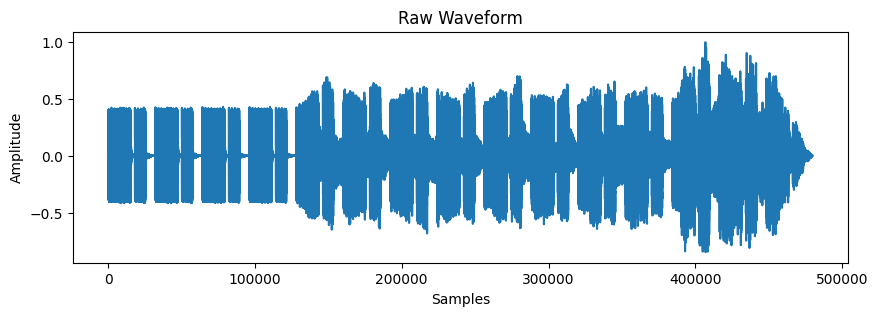

In [6]:
# Load and preprocess audio
waveform, orig_sr = torchaudio.load(AUDIO_FILE)
waveform = waveform.mean(dim=0, keepdim=True)  # Average the audio out
waveform = waveform / waveform.abs().max()  # Normalize to [-1.0, 1.0]
resampler = T.Resample(orig_sr, SAMPLE_RATE)
waveform = resampler(waveform)  # Resample the audio at 16kHz
# Verify waveform normalization
print("Waveform min:", waveform.min().item())
print("Waveform max:", waveform.max().item())
plot_waveform(waveform, SAMPLE_RATE)

Log Mel spectrogram min: -13.815510749816895
Log Mel spectrogram max: 7.4193644523620605
Normalized Manual MFCC min: -11.070804595947266
Normalized Manual MFCC max: 9.43528938293457

Mel spectrogram shape: torch.Size([1, 80, 2999])


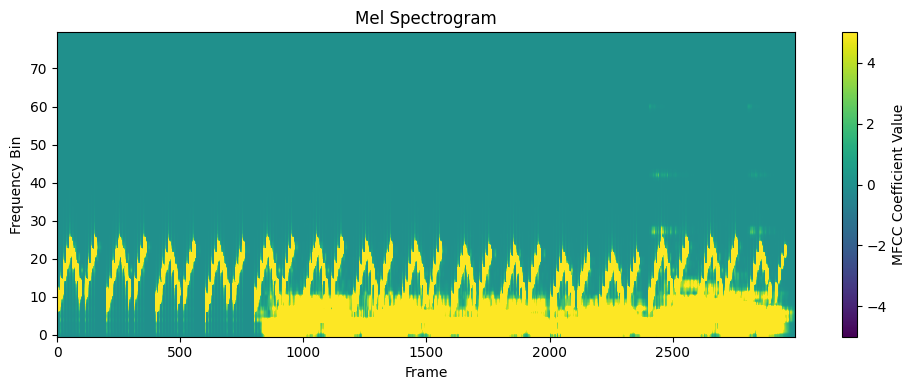


MFCC shape: torch.Size([1, 13, 2999])


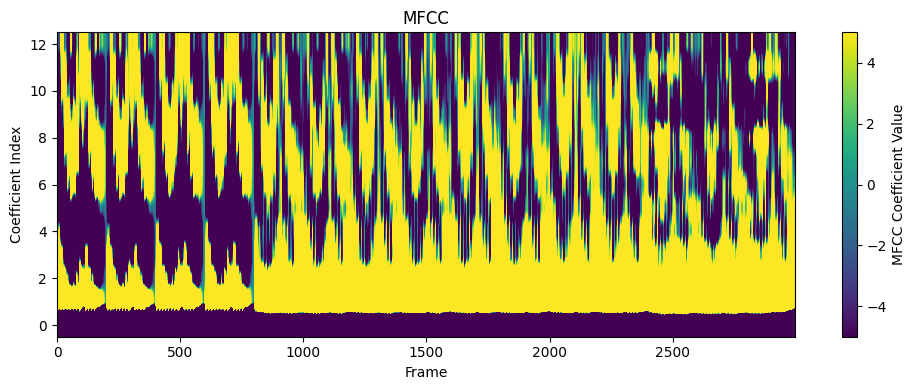

In [12]:
# Compute log Mel spectrogram

# Compute Mel spectrogram
mel_spec = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
)(waveform)


log_mel_spec = torch.log(mel_spec + 1e-6)  # Add a small epsilon to avoid log(0)
print("Log Mel spectrogram min:", log_mel_spec.min().item())
print("Log Mel spectrogram max:", log_mel_spec.max().item())
# Normalize the log Mel spectrogram
log_mel_spec_normalized = (log_mel_spec - log_mel_spec.mean()) / log_mel_spec.std()
# Compute MFCCs manually
mfcc_manual = dct(log_mel_spec_normalized.squeeze(0).numpy(), axis=0, type=2, norm='ortho')[:N_MFCC]
mfcc_manual = torch.from_numpy(mfcc_manual).unsqueeze(0)  # Add batch dimension
# Verifying MFCCs values are reasonable
print("Normalized Manual MFCC min:", mfcc_manual.min().item())
print("Normalized Manual MFCC max:", mfcc_manual.max().item())

mfcc = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={
        'n_fft': N_FFT,
        'hop_length': HOP_LENGTH,
        'n_mels': N_MELS
    }
)(waveform)  # Shape: (1, n_mfcc, num_frames)

print("\nMel spectrogram shape:", mel_spec.shape)
plot_spectrogram(mel_spec, "Mel Spectrogram", "Frequency Bin")

print("\nMFCC shape:", mfcc.shape)
plot_spectrogram(mfcc, "MFCC", "Coefficient Index")


### HuBERT Processing


HuBERT output shape: torch.Size([1, 1498, 768])


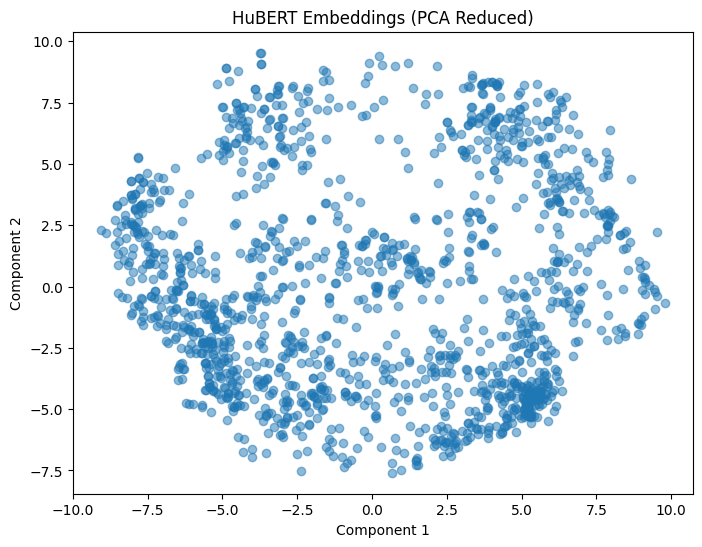

In [13]:
from transformers import Wav2Vec2FeatureExtractor, HubertModel
import torch

# Load the HuBERT feature extractor and model
hubert_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960")

# Process the audio waveform
hubert_inputs = hubert_feature_extractor(
    waveform.squeeze().numpy(),  # Remove batch dimension and convert to numpy
    return_tensors="pt",         # Return PyTorch tensors
    sampling_rate=SAMPLE_RATE    # Specify the sample rate
).input_values  # Extract the processed input values

# Get HuBERT embeddings
with torch.no_grad():
    hubert_output = hubert_model(hubert_inputs).last_hidden_state

# Print the shape of the embeddings
print("\nHuBERT output shape:", hubert_output.shape)

# Visualize the embeddings
visualize_embeddings(hubert_output, "HuBERT Embeddings")

### Wav2Vec 2.0 Processing

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Wav2Vec 2.0 output shape: torch.Size([1, 1498, 768])


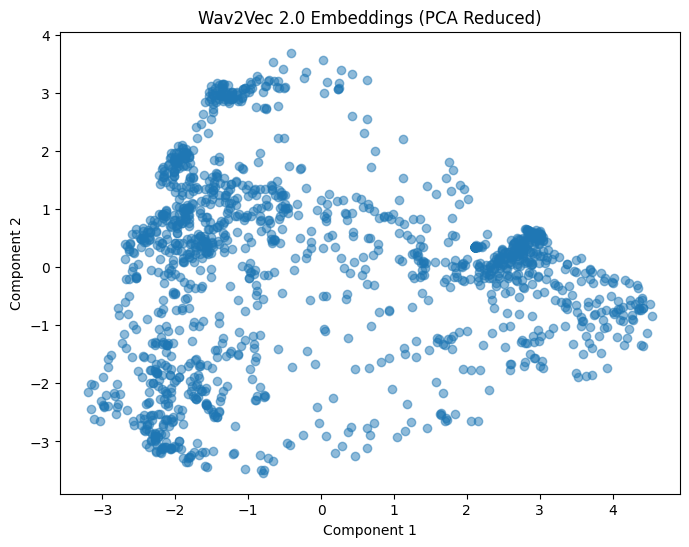

In [14]:
# Wav2Vec 2.0 Processing
w2v_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

w2v_inputs = w2v_processor(
    waveform.squeeze().numpy(),
    return_tensors="pt",
    sampling_rate=SAMPLE_RATE
).input_values

with torch.no_grad():
    w2v_output = w2v_model(w2v_inputs).last_hidden_state

print("\nWav2Vec 2.0 output shape:", w2v_output.shape)
visualize_embeddings(w2v_output, "Wav2Vec 2.0 Embeddings")

### Conformer Processing

Shape of mel_spec: torch.Size([1, 80, 2999])
Shape of mel_spec after adjustment: torch.Size([1, 2999, 80])
Input lengths: tensor([2999], device='cuda:0')
Model output shape: torch.Size([1, 749, 10])


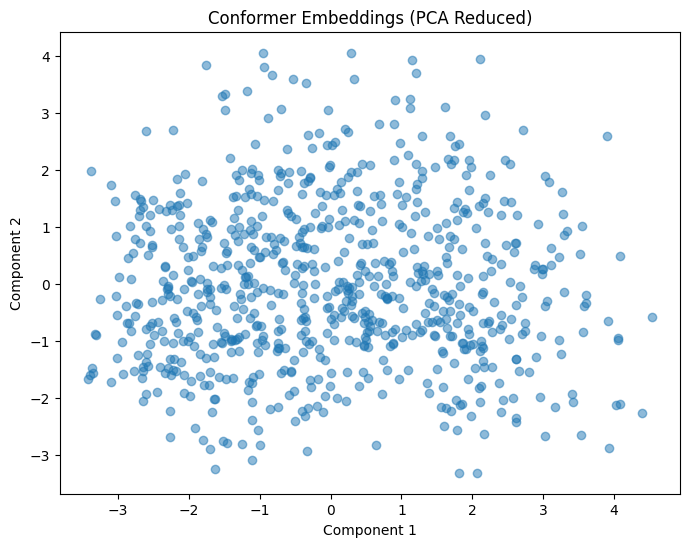

In [15]:
import torch
import torchaudio
import torchaudio.transforms as T
from conformer import Conformer  # Ensure Conformer is properly defined

# Configuration
batch_size, sequence_length, dim = 1, 12345, 80  # Example values; adjust as needed

# Prepare the device
cuda = torch.cuda.is_available()  
device = torch.device('cuda' if cuda else 'cpu')

# Initialize the Conformer model
model = Conformer(num_classes=10, 
                  input_dim=dim, 
                  encoder_dim=32, 
                  num_encoder_layers=3).to(device)

# Assuming mel_spec is already provided and has the shape (1, n_mels, time_steps)
# Check the shape of the mel_spec tensor to make sure it matches the required input format
print(f"Shape of mel_spec: {mel_spec.shape}")  # It should be (1, n_mels, time_steps)

# Ensure the input tensor matches [batch_size, time_steps, feature_dim] format
mel_spec = mel_spec.squeeze(0).transpose(0, 1).unsqueeze(0).to(device)  # Shape: (1, time_steps, n_mels)
print(f"Shape of mel_spec after adjustment: {mel_spec.shape}")  # It should now be (1, time_steps, n_mels)

# Create input_lengths: The length of the sequence (time_steps) for this example
input_lengths = torch.LongTensor([mel_spec.size(1)]).to(device)  # The time_steps length
print(f"Input lengths: {input_lengths}")

# Forward pass through Conformer (No targets or CTC loss)
with torch.no_grad():
    outputs, output_lengths = model(mel_spec, input_lengths)

# Print the model output shape
print("Model output shape:", outputs.shape)
visualize_embeddings(outputs, "Conformer Embeddings")

### Performer Processing (example implementation)

unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version

Performer output shape: torch.Size([1, 2999, 64])


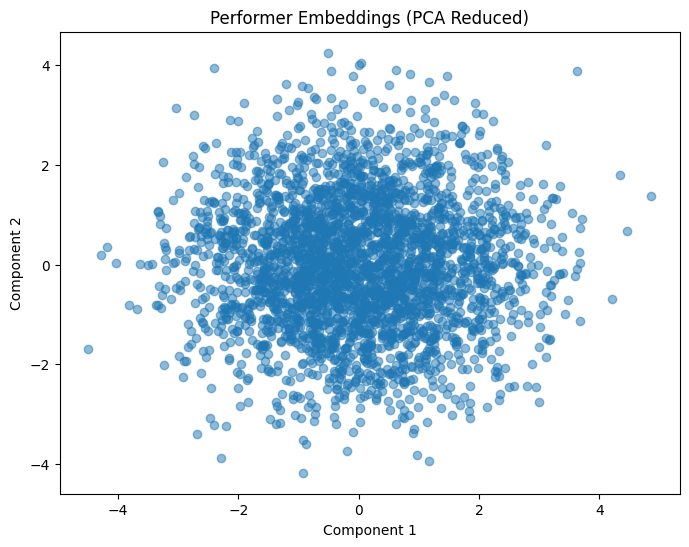

In [19]:
import torch
import torch.nn as nn
from performer_pytorch import Performer

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Performer model
performer = Performer(
    dim=64,        # Embedding dimension
    depth=4,       # Number of layers
    heads=8,       # Number of attention heads
    dim_head=64,   # Dimension of each attention head
    causal=True    # Causal masking (optional)
).to(device)

# Define a projection layer to map 80 Mel bins to 64 dimensions
projection = nn.Linear(80, 64).to(device)

# Example Mel spectrogram input
mel_spec = torch.randn(1, 80, 2999)  # Shape: (batch_size, n_mels, num_frames)

# Prepare the input features
mel_spec = mel_spec.transpose(1, 2)  # Shape: (batch_size, num_frames, n_mels)
mel_spec = mel_spec.to(device)

# Project the input features to the expected dimension
performer_input = projection(mel_spec)  # Shape: (batch_size, num_frames, 64)

# Pass the input through the Performer model
with torch.no_grad():
    performer_output = performer(performer_input)

print("\nPerformer output shape:", performer_output.shape)
visualize_embeddings(performer_output, "Performer Embeddings")